# Geodesic Convolution

In this post shows an idea to generalise convolutional layers from images (functions on $\mathbb{R}^2$) to functions on triangulated manifolds. It will focus on the convolution of a kernel with a function. In a future post we will address the problem of input channels and output channels. The ideas presented here are based on the papers [Geodesic Convolutional Neural Networks on Riemannian Manifolds](https://www.cv-foundation.org/openaccess/content_iccv_2015_workshops/w22/papers/Masci_Geodesic_Convolutional_Neural_ICCV_2015_paper.pdf) and [Intrinsic shape context descriptors for deformable shapes](https://www.tau.ac.il/~roeelitm/KokBroLitBroCVPR12.pdf).

---
Post Structure:
- Theory: introducing the idea and explaining the motivation
- The Kernel: The kernel used in the examples
- Example 1: The Sphere
- Example 2: The Body
---

The idea behind standard convolutional layer in a neural network is to extract local information about the function/image. Typically this is done using weights from a kernel. This local information can become more and more abstract by adding multiple convolutional layers after one another. The way of extracting information is the same on the entire image, using this type of weight sharing greatly reduces the dimension of the weight space, and should make training a model simpler.

If the input is an image, then the network takes a local weighted average around a point. This operation is represented by the convolution operator.
$$
\begin{align*}
f\star g (x) = \sum_{n}f(n)g(x-n)
\end{align*}
$$
In the case of the image, the underlying structure is flat $2$ dimesnional euclidean space, and the pixels are spaced out evenly. In the case of a triangulated surface with a function, one cannot use this definition of the convolution, e.g. substraction is not defined on the triangulated manifold. 

Still the idea implemented here is the same, the layer should extract local information of the function around a points. Similar as in the article we explain the idea of an patch and then define the Geodesic Convolution. 

---

## Patch

Around each point we will have a neighborhood that is equivalent to a disk. On this disk we can define our kernel and then define the convolution by using this map from the neighborhood to the disk. 

More formally, define the set $B_r(x): \{ y \in M | d(x,y) < r\}$ the set of all point such that the geodesic distance is smaller than $r$. Additionally we can compute the actual geodesic between the points $y$ and $x$. These geodesics have a representative tangent vector in the tangent space $T_xM$. After choosing a basis of the tangent space we can calculate the angles of the vectors denote this angle as $\Theta_x(y)$. This way we can make a function 
$$
\begin{align*}
\phi_x & : B_r(x) \to D_r\\
y & \mapsto (d(x,y), \Theta_x(y))
\end{align*}
$$

Note that this definition of a patch only makes sense if $r$ is small enough, such that $B_r(x)$ is actually topological equivalent to a disk. This makes sure that the cut locus is not represented in the disk, meaning the function approximates a continuous function.  

Then the geodesic convolutional operator is defined as $(f\star k) (x) = \sum_{\rho, \theta} d_xf(\rho,\theta)k(\rho, \theta)$ with $d_xf(\rho,\theta):= f(\phi_x^{-1}(\rho,\theta)$.

### Tangent Vectors

Given a triangulated surface, how does one speak of a tangent space at a point, this point where triangles come together, will not have a natural tangent space. We overcome this issue, by mapping the neighborhood to $\mathbb{R}^2$ by keeping the ratio of triangle angles the same.  

### Interpolation

The function is only defined on the vertices of the manifold, then $D_xf(\rho,\theta):= f(\phi_x^{-1}(\rho,\theta))$ might not always be well defined. 

Therefor we change the definition slightly to an expected value

$$
\begin{align*}
D_xf(\rho,\theta) = \mathbb{E}[d_xf(\rho,\theta)] & = \int_{\rho', \theta'} p_{\rho,\theta}(\rho',\theta') d_xf(\rho', \theta') d\rho' d\theta' \\
& = \int_y p_{\rho,\theta}(y) f(y) dy \\
& = \sum_y p_{\rho,\theta}(y) f(y) \mu(y)
\end{align*}
$$

The measure $\mu$ is the vertex area, this is defined as a third of the sum of the areas of adjacent triangles. 

As probability function we use the $\phi_x$ to obtain $\rho_y, \theta_y$, transforming this to euclidean coordinates we can calculate the distance between the point and $\rho, \theta$, denoted as $d_{\rho,\theta}(y)$, then the probability distribution is defined as 

$$
\begin{align*}
p_{\rho,\theta}(x) = \frac{\exp(-\frac{d_{\rho,\theta}(x)^2}{2\sigma^2})}{\sum_y \exp(-\frac{d_{\rho,\theta}(y)^2}{2\sigma^2})}
\end{align*}
$$

The $\sigma$ parameter is chosen to be $0.3$, simply because is gives visually pleasing results. 

Then final version of the geodesic convolutional operator is defined as 
$$(f\star k)(x) = \sum_{\rho, \theta} D_xf(\rho,\theta)k(\rho, \theta)$$.
# Notes

This method has a drawback, namely we have to choose a basis. Therefor the orientation of the patch is not consistant. The reason why we have to choose a basis is because there is not a natural way of making a mapping between two points. This is something the image convolution did have. Furthermore, with image convolutions one can set stepsizes to reduce the height and width of an image, this does not have an equivalent in the triangulated case.

This method is dependent on a couple choices, and more research needs to be done to find the best. The choices being
- The creation of the patches.
- The interpolation of the function

In [1]:
import sys
import vtki
import torch
import scipy
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

from plyfile import PlyData, PlyElement
from tqdm import tqdm
from vtki import PolyData
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

# Home made modules
from modules.trimesh import trimesh
from modules.fast_marching_method import FMM
from modules.gradient_walk.linear_walk import LinearWalk
from modules.adj_matrix import adjacency_matrix_fmm
from modules.geometry_functions import laplace_beltrami_eigenfunctions

%matplotlib inline
%load_ext autoreload
%autoreload 2

A function to load the mesh

In [2]:
def trimesh_from_ply(f_name):
    data = PlyData.read(f_name)
    
    data_vert = np.vstack([list(vertex) for vertex in data['vertex'].data])
    data_tri = np.vstack(data['face'].data['vertex_indices'])
    return trimesh(data_vert,data_tri)

# Bin parameter
p_bins = 5
t_bins = 16

---

# The kernel

Since this method chooses an orientation of the kernel randomly, we take a kernel that is rotation invariant. The kernel is the gaussian kernel.

Below we construct the kernel

---

In [3]:
# Some small functions
p_exp = lambda x, y: np.exp(-x**2/(2*y**2))
p_trans = lambda r: r/p_bins
t_trans = lambda t: 2*np.pi*t/t_bins

def plot_disk(t,r,z):
    fig = plt.figure()

    plt.subplot(projection="polar")
    plt.pcolormesh(t, r, z)
    plt.grid()

    plt.show()

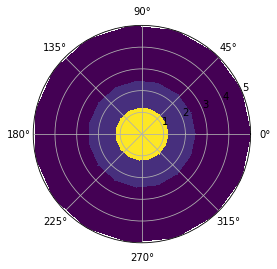

In [4]:
# Make the kernel and plot it
rad = np.linspace(0, 5, p_bins)
azm = np.linspace(0, 2 * np.pi, t_bins)
r, th = np.meshgrid(rad, azm)

def make_kernel(p_bins,t_bins):
    kernel = np.zeros((t_bins, p_bins))

    for i in range(p_bins):
        r_1 = p_trans(i)
        val = p_exp(r_1, .1)
        for j in range(t_bins):
            kernel[j,i] = val
    return kernel/kernel.sum()

kernel = make_kernel(p_bins, t_bins)
plot_disk(th, r , kernel)

In [5]:
# A function that returns the vertex areas
def vertex_area(mesh):
    tri = mesh.vertices[mesh.triangles]
    tri_area = np.linalg.norm(np.cross(tri[:,0]-tri[:,2], tri[:,1]-tri[:,2]), axis = 1)/6
    A_mat = np.zeros(len(mesh.vertices), dtype = np.float32)
    for i, t in enumerate(mesh.triangles):
        t1, t2, t3 = t
        A_mat[t1] += tri_area[i]
        A_mat[t2] += tri_area[i]
        A_mat[t3] += tri_area[i]
        
    return A_mat
    

In [6]:
# A matrix containing the distance probabilities
rho = list(range(p_bins))
theta = list(range(t_bins))
rho_o, theta_o = np.meshgrid(rho,theta)
rho, theta = p_trans(rho_o.T), t_trans(theta_o.T)
y1 = (rho*np.cos(theta)).reshape(-1)
y2 = (rho*np.sin(theta)).reshape(-1)
y = np.stack([y1,y2]).T
dist = np.zeros((80,80), dtype = np.float32)

p_exp = lambda x, y: np.exp(-x**2/(2*y**2))

for i in range(80):
    for j in range(80):
        y1 = y[i]
        y2 = y[j]
        d = np.linalg.norm(y1 - y2)
        dist[i,j] = p_exp(d, .3)
    
dist = dist/dist.sum(1, keepdims = True)

---

To make use of 'easy' matrix multiplications. We make a matrix that contain the respective probablity and vertex area already. If $N$ is the number of vertices and $B$ the number of bins then the function below return a $N\times N \times B$ matrix. 

This matrix contain for a vertex $i$ a matrix of size $N\times B$. In each column the values $p_{\rho,\theta}(y)\mu(y)$ are stored. 

This $N\times B$ matrix should afterwards be multiplied on the left by $[f(v_1) \cdots f(v_n)]$ to get the patch function $[D_xf(b_1) \cdots D_xf(b_B)]$. For the convolution with the kernel the innerproduct with the kernel should be taken. 

The order of multiplication can be changed for efficiency, incase you want the same kernel and many different function, or one function and many different kernels

**note** This matrix is very sparse. Thus the code might benifit from sparse methods. 

In [7]:
def big_prob_mat(mesh, adj_mat, dist = dist):
    N = adj_mat.shape[0]
    B = adj_mat.shape[1]//N
    
    A_mat = vertex_area(mesh)
    
    p_mat = adj_mat.toarray().reshape((N,N,B))
    
    # Insert the vertex areas
    # [N,N,B] hadamard [1,N,1]
    p_mat = np.multiply(p_mat, A_mat[np.newaxis,:,np.newaxis])
    
    # Insert the probabilities and normalise
    # [N,N,B] [N,B,B] => [N,N,B]
    p_mat = np.matmul(p_mat, dist)
    p_mat = p_mat/p_mat.sum(axis =1, keepdims = True)
    
    return p_mat

---

# Example 1: The Sphere

In this example we take the isohedral sphere.

In [8]:
# open the mesh
file_sphere = '../test_data/sphere_iso_6c.ply'
sphere = trimesh_from_ply(file_sphere)

The below function creates the adjacency matrix:
The innerworking can be described as 
- for each vertex do
    - find the points in a certain geodesic radius
    - find for each of these points the geodesic
    - bin each point in a angular and radial bin
- return the matrix

Right now the matrix has dimension NxNxPxT, where N are the number of vertices P the number of radial bins and T the number of angular bins. 

In [9]:
# Make the adjacency matrix
adj_sphere = adjacency_matrix_fmm(sphere, p_max = .5, p_bins = p_bins, t_bins = t_bins)

100%|██████████| 642/642 [05:42<00:00,  1.61it/s]


In [10]:
# Make a sparse matrix out of the adjacenct matrix. 
sparse_sphere = scipy.sparse.csr_matrix(adj_sphere.reshape(len(sphere.vertices),-1))

In [11]:
%%time
prob_mat = big_prob_mat(sphere, sparse_sphere)

CPU times: user 576 ms, sys: 205 ms, total: 780 ms
Wall time: 995 ms


In [12]:
# Our function has value 1 on a vertex and is zero otherwise.
func = np.zeros(len(sphere.vertices))
func[0] = 1

# The convoluted function
Df = np.matmul(func.reshape(1,-1), prob_mat)
f_conv = np.matmul(Df, kernel.T.reshape(-1,1))

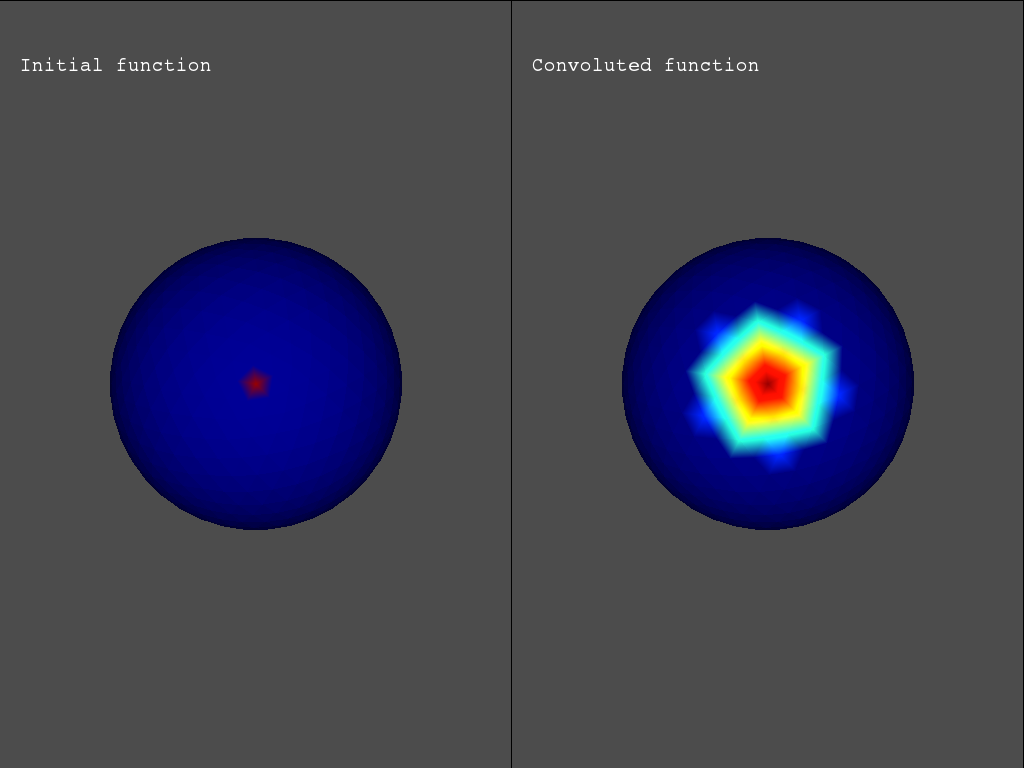

In [13]:
# Plotting the original and the convoluted function. 
plotter = vtki.Plotter(shape=(1, 2))

color_map = 'jet'

plotter.subplot(0,0)
polydata = PolyData(sphere.vertices, np.c_[[[3]]*len(sphere.triangles),sphere.triangles])
plotter.add_text('Initial function', position=None, font_size=20)
plotter.add_mesh(polydata, scalars = func, cmap = color_map)
plotter.view_vector([0,0,-1], viewup = [1,1,0])


plotter.subplot(0, 1)
polydata = PolyData(sphere.vertices, np.c_[[[3]]*len(sphere.triangles),sphere.triangles])
plotter.add_text('Convoluted function', position=None, font_size=20)
plotter.add_mesh(polydata, scalars = f_conv, cmap = color_map)
plotter.view_vector([0,0,-1], viewup = [1,1,0])
                 
plotter.show()

# Example 2: The body

This example show a body traingulation of from the [FAUST](http://faust.is.tue.mpg.de) dataset. This triangulation is a bit more irregular than the sphere. 

We have already precomputed the adjacency matrix (hardbinning), to calculate this would take roughly one hour. To make the adjacency matrix we have used the following settings:
- `p_max = 0.03`
- `t_bins = 16`
- `p_bins = 5`


In [14]:
file_adj = '../test_data/tr_reg_004_raw.npz'
file_body = '../test_data/tr_reg_004.ply'

p_bins = 5
t_bins = 16
adj_mat = scipy.sparse.load_npz(file_adj)
body = trimesh_from_ply(file_body)

---

We will use the same kernel. We will already precompute the matrix, so that we only need to multiply with the function in the end. The function that will be examined are a function similar to the case of the sphere and a more interesting function, namely and eigenfunction of the laplace beltrami operator. 

---

In [15]:
%%time
prob_mat_body = big_prob_mat(body, adj_mat)
p_kern = np.matmul(prob_mat_body,kernel.T.reshape(-1,1))

CPU times: user 1min 27s, sys: 1min 52s, total: 3min 19s
Wall time: 3min 4s


---

First the function with $1$ on a vertex and zero elsewhere. In the end we see nice result, because the number of vertices here is more dense than in the case of the sphere it actually looks smoother. 

---

In [16]:
ind = 500
f = np.zeros(6890)
f[ind] = 1

In [17]:
f_conv = np.matmul(f.reshape(1,-1), p_kern).squeeze()

In [18]:
# The function to make the images. 
#body.vtki_plot(ind = [ind], color = f)

<div style="display: block">
<img src="./images/conv_1.png" width="450", style="display: block; float: left;"/><img src="./images/conv_2.png" width="450" style="display: block; float: left;"/>
</div>

---


### Laplace Beltrami Eigenfunctions

The function on which we will take the convolution is the an eigenvector of the laplace beltrami operator with added noise. The kernel will again be the gaussian kernel, ideally this kernel should be able to help with the noise that we added. 

---

In [19]:
# get a laplace function
val, vec = laplace_beltrami_eigenfunctions(body,k = 50)

# To make sure we get the same result
np.random.seed(0)
laplace_func_orig = vec[:,20]
laplace_func = laplace_func_orig + np.random.normal(scale = .15, size = len(laplace_func_orig))

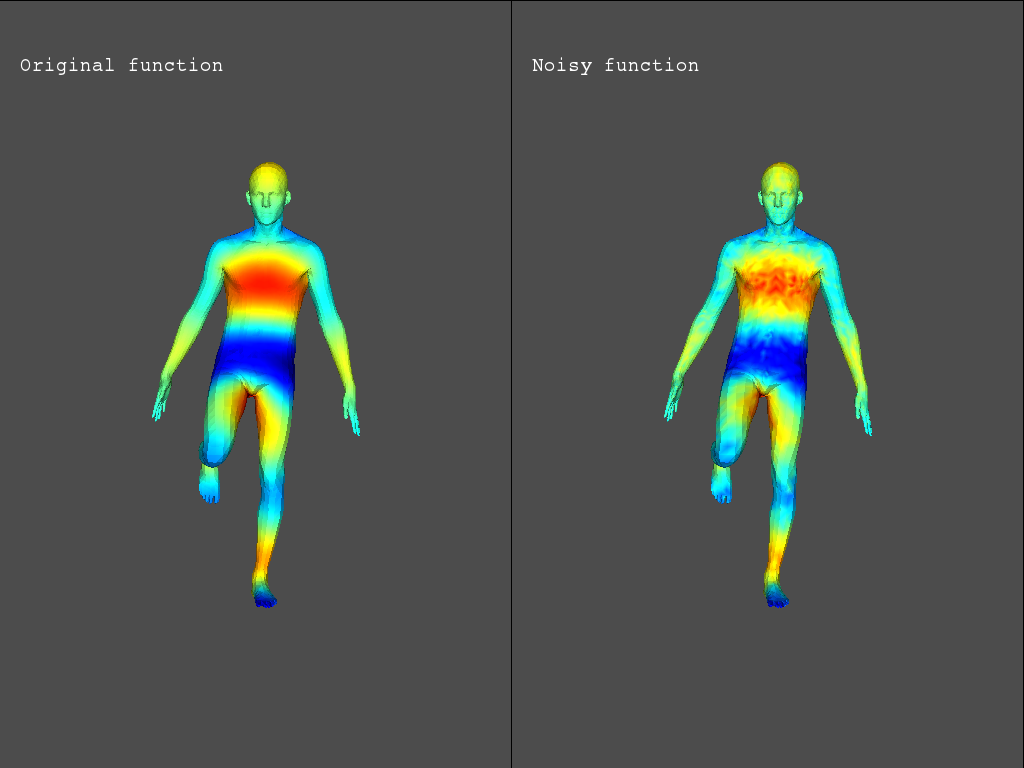

In [20]:
# Plotting the original and the convoluted function. 
plotter = vtki.Plotter(shape=(1, 2))

color_map = 'jet'

plotter.subplot(0,0)
polydata = PolyData(body.vertices, np.c_[[[3]]*len(body.triangles),body.triangles])
plotter.add_text('Original function', position=None, font_size=20)
plotter.add_mesh(polydata, scalars = laplace_func_orig, cmap = color_map)
plotter.view_vector([0,0,1], viewup = [0,1,0])


plotter.subplot(0, 1)
polydata = PolyData(body.vertices, np.c_[[[3]]*len(body.triangles),body.triangles])
plotter.add_text('Noisy function', position=None, font_size=20)
plotter.add_mesh(polydata, scalars = laplace_func, cmap = color_map)
plotter.view_vector([0,0,1], viewup = [0,1,0])
                 
plotter.show()

In [21]:
%%time
# Apply the convolution
f_conv = np.matmul(laplace_func.reshape(1,-1), p_kern).squeeze()

CPU times: user 69.3 ms, sys: 5.28 ms, total: 74.6 ms
Wall time: 82.5 ms


---

If we plot the convoluted function, we see a nice smoothing of the noise.

---

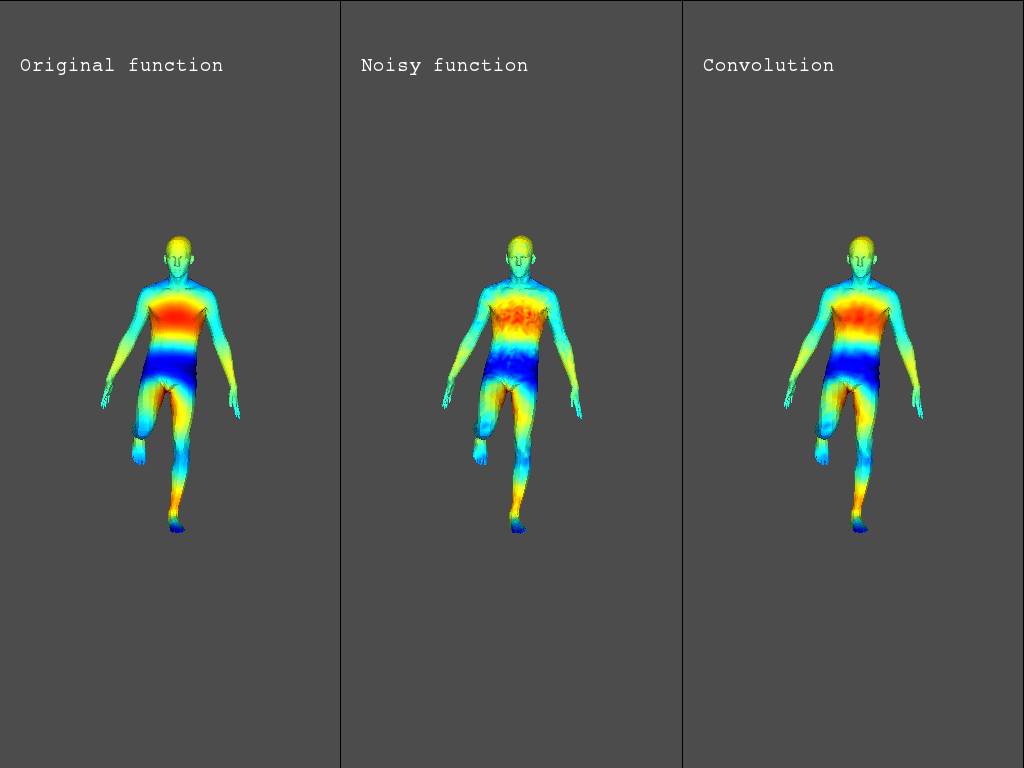

In [22]:
# Plotting the original and the convoluted function. 

plotter = vtki.Plotter(shape=(1, 3))

color_map = 'jet'

plotter.subplot(0,0)
polydata = PolyData(body.vertices, np.c_[[[3]]*len(body.triangles),body.triangles])
plotter.add_text('Original function', position=None, font_size=20)
plotter.add_mesh(polydata, scalars = laplace_func_orig, cmap = color_map)
plotter.view_vector([0,0,1], viewup = [0,1,0])


plotter.subplot(0, 1)
polydata = PolyData(body.vertices, np.c_[[[3]]*len(body.triangles),body.triangles])
plotter.add_text('Noisy function', position=None, font_size=20)
plotter.add_mesh(polydata, scalars = laplace_func, cmap = color_map)
plotter.view_vector([0,0,1], viewup = [0,1,0])
                 
plotter.subplot(0,2)
polydata = PolyData(body.vertices, np.c_[[[3]]*len(body.triangles),body.triangles])
plotter.add_text('Convolution', position=None, font_size=20)
plotter.add_mesh(polydata, scalars = f_conv, cmap = color_map)
plotter.view_vector([0,0,1], viewup = [0,1,0])


plotter.show()

---

As an extra check to see that the convolution does what we expect we plot the function values, with their index on the xaxis. Note there is no guarentee that adjacent indices are neighbors or even close together. The convolution removes the noise in the function and becomes closer to the actual function. As we would expect.

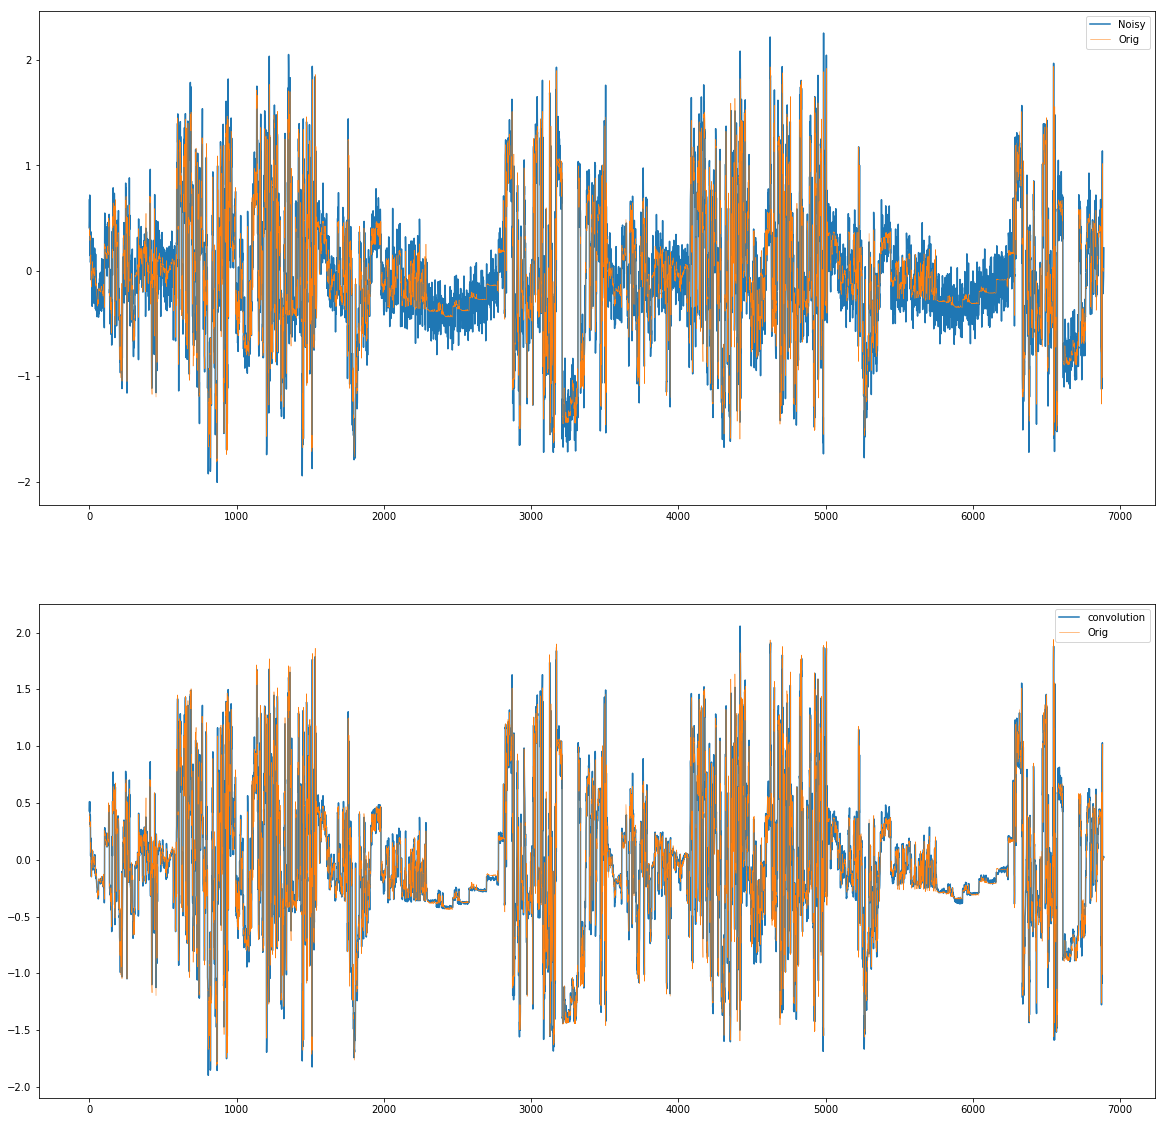

In [23]:
fig, ax = plt.subplots(2, figsize = (20,20))
ax[0].plot(laplace_func, label = 'Noisy')
ax[0].plot(laplace_func_orig, label = 'Orig', linewidth = .5)
ax[0].legend()

ax[1].plot(f_conv, label = 'convolution')
ax[1].plot(laplace_func_orig, label = 'Orig', linewidth = .5)
ax[1].legend()
